In [10]:
import numpy as np
import networkx as nx
import scipy.integrate as odeint
import matplotlib as mpl
import matplotlib.pyplot as plt
import math 
import csv
from colours import color



ModuleNotFoundError: No module named 'colours'

In [8]:
def Save_the_net(Net,res,T):
    #First values are net parameters in this order
    noise = Net.noise_A
    nats  = Net.state_nats
    states = Net.state_init
    dt = Net.dt
    write_me = [Net.noise_A,Net.state_nats,Net.state_init]
    return

def Load_the_net(file):
    return
# class Oscillator:
#     def __init__(self,nat):
#         self.nat = nat  # nat freq of oscillator
        
#     def update(self,int): # function takes in a interaction 
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
def rgb_spectrum_line(value): # NEEDS OPACITY AND TUNING 
    if value == 0: 
        rgb = np.array([1.0,1.0,1.0]) # white 
    elif value < 0:
        rgb = abs(value)*np.array([1.0,0.0,0.0]) # yellow if < 0 
    else:
        rgb = abs(value)*np.array([0.0,0.0,1.0]) # blue >0
    return rgb
        
def RunAndPlot(Qnat,Qup,time,net,res,N,k,var,mean,connectivity):
    results = np.zeros((res,N))
    theta  = np.zeros((res,N))
    for i in range(0,len(time)):
        theta[i,:] = net.state[:,0]
        results[i,:] = np.sin(net.state[:,0]) 

        net.Update(Qnat,Qup)
    fig, ax = plt.subplots()
    for i in range(N):
        ax.plot(time,results[:,i],color='purple', alpha=0.1) 
        
    ax.set_ylim([-1, 1.1])

    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel(r"sin $\theta $")
    ax.set_title(f'k = {k}, Var = {var}, Mean = {mean} , P = {connectivity} ,N = {N}')
    fig, ax = plt.subplots()
    # print(np.exp(1j*results))
    # print(np.mean(np.exp(1j*results)))
    OP = np.abs(np.mean(np.exp(1j*theta), axis=1))
    ax.plot(time, OP)
    ax.set_ylim([-0, 2])


    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Order Parameter')

    fig, ax = plt.subplots()
    for i in range(0,net.n):
        ax.plot(time,net.nat_hist[i][0:-1])
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel(r"Natural Frequencies")
    ax.set_title(f'k = {k}, Var = {var}, Mean = {mean} , P = {connectivity} ,N = {N}')
    
    
    ax = plt.axes(projection='3d')
    for i in range(0,N):
        ax.plot3D(np.cos(theta[:,i]), np.sin(theta[:,i]), time, 'black',alpha = 0.1)
    

class Net:
    def __init__(self,Adj,n,k,dt,var,mean):
        self.Adj = Adj#Adjacency with weighted and dircetional couplings
        self.n = n
        self.dt = dt
        self.k = float(k)
        self.nat_hist = []
        self.noise_A = 0.1
        self.space = [] #3 dimensional vectors in node based vector. 
        # NEEDS GENERATOR
        self.state = 0 + self.noise_A*np.random.randn(self.n,1) #  np.random.uniform(-2*np.pi,2*np.pi,(n,1))  # nx1 vector of current oscillator  states
        self.state_init = self.state
        #print('init state = {}'.format(self.state))
        self.nats = np.zeros((n,1)) + self.noise_A*0.01*np.random.randn(self.n,1) # 2*np.pi*dt*np.random.normal(mean,var,(n,1)) # Vector of natural freqs, currently all unity for simplicity. 
        self.state_nats = self.nats 
        #print('init nats = {}'.format(self.nats))
        self.I = np.zeros((n,1))
        self.Iw = np.zeros((n,1))
        self.graph = nx.from_numpy_array(self.Adj)
        self.pos = nx.kamada_kawai_layout(self.graph)
        self.nat_hist = self.nats
     
    def reinit(self):
        self.nats = self.state_nats  
        self.state = self.state_init 
        self.nat_hist = self.nats
        
    def Gauss_Space(self,space_mean,space_var):
        self.space = np.random.normal(space_mean,space_var,(self.n,2))
        self.pos = self.space
 
    def distribute_adj(self,distribution):
        if distribution == 'uni':
            self.Adj = self.Adj * np.random.uniform(-1,1,self.Adj.shape)

    def R2Connect(self):
        for i in range(self.n-1):
            for j in range(i+1,self.n): 
                    if j != i: 
                        xi = self.space[i,:]
                        xj = self.space[j,:]
                        r2 = (np.linalg.norm(xi-xj))**2
                        self.Adj[i,j] = self.k/(1 + r2)
                        self.Adj[j,i] = self.k/(1 + r2)
                        
    def ProbConnect(self,a,P_inhib):
        # -a is power law exponent
        for i in range(self.n-1):
            for j in range(i+1,self.n): 
                if j != i:
                    pool = np.zeros([10000,1])
                    inhib_pool = np.ones([10000,1])
                    xi = self.space[i,:]
                    xj = self.space[j,:]
                    s = np.abs(xi-xj)
                    mag = np.sqrt(s[0]**2 + s[1]**2)# + s[2]**2 )
                    prob_connect = 1/(mag**a+1) # connection law. +1 is offset to normalise ## CHANGE to control connectivity
                    connect_num = np.round(len(pool)*prob_connect)
                    pool[1:int(connect_num)] = 1
                    np.random.shuffle(pool)
                    inhib_num = np.round(len(pool)*P_inhib)
                    pool[1:int(inhib_num)] = -1
                    np.random.shuffle(inhib_pool)
                    self.Adj[i,j] = (1/mag)*pool[np.random.randint(0,len(pool))]*inhib_pool[np.random.randint(0,len(pool))]
                    self.Adj[j,i] = (1/mag)*pool[np.random.randint(0,len(pool))]*inhib_pool[np.random.randint(0,len(pool))]
                else:
                    continue
    
    def Mesh(self):
        
        x = np.linspace(0,100,self.rtn)
        y = np.linspace(0,100,self.rtn)
        xv,yv = np.meshgrid(x,y,indexing = 'ij')
        
        # Build Adj for grid 
        # Check all 4 directions
        self.Adj = np.zeros((self.rtn,self.rtn)) # RESET ADJ
        for i in range(self.rtn):
            for j in range(self.rtn):
                self.pos[i,j] = [xv[i,j],yv[i,j]] # update position for plotting
                if i - 1 >= 0:
                    self.Adj[i-1,j] = self.k
                if i + 1 < self.rtn: 
                    self.Adj[i+1,j] = self.k
                if j - 1 >= 0:
                    self.Adj[i,j-1] = self.k  
                if j + 1 < self.rtn: 
                    self.Adj[i,j+1] = self.k
        print(f"Grid{self.Adj}")                 
        # Couple if exist. 
    
    def Update(self,query_nat, query_update):
    
        for i in range(self.n):
            I_n = 0
            I_f = 0
            for j in range(self.n):
                if query_nat == False:
                    if self.Adj[i,j] != 0:
                        I_n += self.Adj[i,j]*np.sin(self.state[j] - self.state[i])*self.dt # update value of phase
                    if query_update == True:
                        if i != j:    
                            self.Adj[i,j] = np.cos(self.nats[j]-self.nats[i])# update coupling
                ## SECOND ORDER UPDATING
                if query_nat == True:
                    if self.Adj[i,j] != 0: # if not itself
                        I_f += self.Adj[i,j]*np.sin(self.state[j] - self.state[i])*self.dt
            self.I[i] = I_n
            self.Iw[i] = I_f #*1/self.n
        #print('pre state = {}'.format(self.state))
         #*1/self.n #+ self.noise_A*np.random.randn(self.n,1)
        if query_nat == True:
            self.nats +=  self.Iw*1/self.n
            self.state += self.nats + self.I
        self.nat_hist= np.append(self.nat_hist,self.nats,1)
        #print('post state = {}'.format(self.state))
        
    def View(self):
        self.graph = nx.from_numpy_array(self.Adj)
        #edge colours should be realted to normalised weights 
        
        #node colours should be current phase
        color_map = []
        # for i in range(self.n):
        #     color_map.append(cyclic_rgb(self.state[i]))
        # print(color_map)  
        Order = np.arange(0, self.n, 2)
        Order = np.hstack((Order, np.arange(self.n-1, 0, -2)))
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 8))
        ax = axs[0]
        # colormap(jet)
        ax.pcolormesh(self.Adj[Order, :][:, Order],cmap=mpl.colormaps['Spectral'])

        ax.set_xlabel('Nodes')
        ax.set_ylabel('Nodes')
        ax.set_title('Coupling Matrix')
        ax.axis('square')
        red = Color("red")
        colors = list(red.range_to(Color("green"),10))
        #nx.draw(self.graph,node_color=color_map,pos=self.pos) # BROKEN WITH EVOLUTIONS 
        
        
        ax = axs[1]
        # normalise weights
        norm_adj = np.zeros_like(self.Adj) 
        signed_norm_adj = np.zeros_like(self.Adj) 
        for i in range(0,self.n):
            for j in range(0,self.n):    
                norm_adj[i,j] = (abs(self.Adj[i,j]) - abs(self.Adj).min())/(abs(self.Adj).max() - abs(self.Adj).min())*(1)
            signed_norm_adj = norm_adj*np.sign(self.Adj)
        #print(norm_adj)
        for i in range(0,self.n):
            
            for j in range(i,self.n):
                if self.Adj[i,j] != 0:
                    #print(rgb_spectrum_line(norm_adj[i,j]))
                
                    plt.plot([self.pos[i][0],self.pos[j][0]],[self.pos[i][1],self.pos[j][1]],linestyle = '-',color = rgb_spectrum_line(signed_norm_adj[i,j]),alpha = norm_adj[i,j])
            plt.scatter(self.pos[i][0],self.pos[i][1])
            
            
        # ax = axs[2]
        # pos_phase = [np.cos(self.state),np.sin(self.state)]
        # for i in range(0,self.n):
        #     for j in range(0,self.n):    
        #         norm_adj[i,j] = (abs(self.Adj[i,j]) - abs(self.Adj).min())/(abs(self.Adj).max() - abs(self.Adj).min())*(1)
        #     signed_norm_adj = norm_adj*np.sign(self.Adj)
        # #print(norm_adj)
        # for i in range(0,self.n):
            
        #     for j in range(i,self.n):
        #         print(rgb_spectrum_line(norm_adj[i,j]))
        #         plt.plot([pos_phase[i][0],pos_phase[j][0]],[pos_phase[i][1],pos_phase[j][1]],linestyle = '-',color = rgb_spectrum_line(signed_norm_adj[i,j]),alpha = norm_adj[i,j])
        #     plt.scatter(pos_phase[i][0],pos_phase[i][1])
        
        
                
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''       
        # print('th0 {}'.format(self.state))
        # self.sins = np.sin(np.subtract.outer(self.state, np.transpose(self.state))) #sines of differences
        # #print(np.outer(self.state, np.transpose(self.state)))
        # #print('sin {}'.format(np.sin(np.subtract.outer(self.state, np.transpose(self.state)))))
        
        # #print('sins {}'.format(self.sins))
        # self.I = np.sum(np.multiply(self.Adj,self.sins), axis=0) # I is sum of contributions on each oscillator
        # print(np.multiply(self.Adj,self.sins))
        # print('I {}'.format(self.I))
        # self.state += self.nats + self.I
        # #print('nat = {}'.format(self.nats*dt))
        # #print('th1 {}'.format(self.state))
       
''' 
Can't interact with adjacency here 
''' 
    # def theta_dot(self,t,angles_vec):
    #     angles_i, angles_j = np.meshgrid(angles_vec, angles_vec)
    #     I = self.Adj* np.sin(angles_j - angles_i)
    #     dxdt = self.nats + I.sum(axis=0)
    #     return dxdt
    
    # def Run(self,dt,T):
    #     t = np.linspace(0, self.T, int(self.T/self.dt))
    #     timeseries = odeint(self.derivative, self.state, t)
    #     return timeseries
        
        


" \nCan't interact with adjacency here \n"

new adj[[ 0.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  0.]]


NameError: name 'Color' is not defined

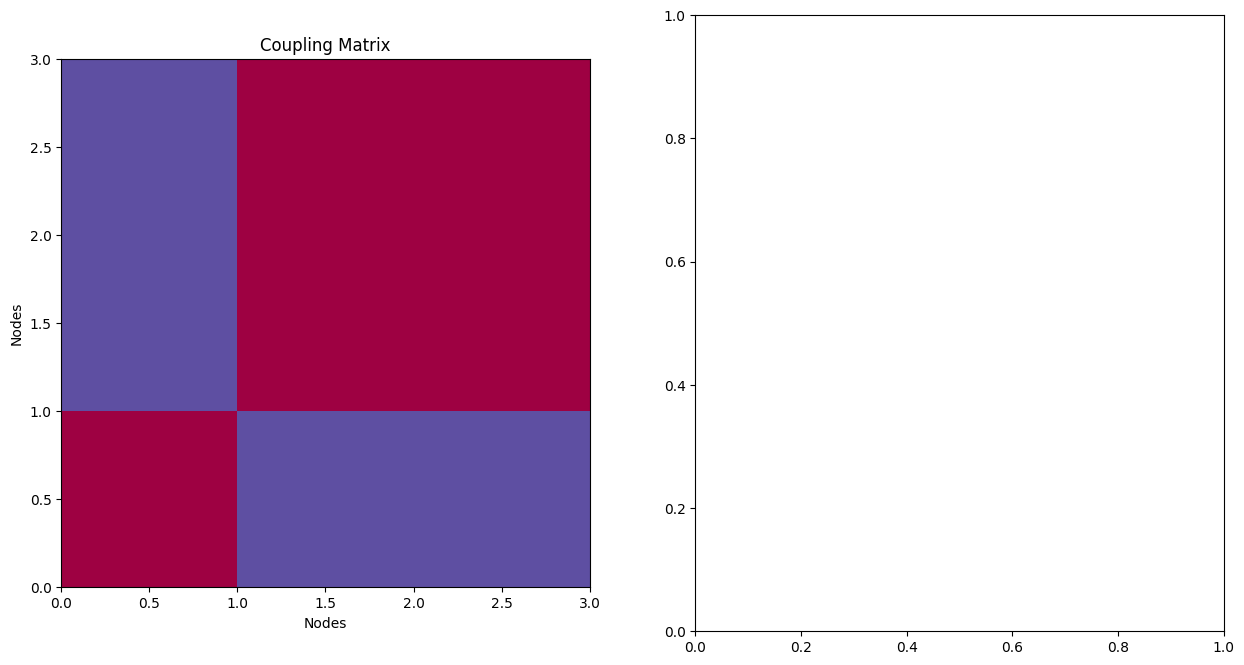

In [9]:
# test = [[0,10],[10,0]] # test adj with linear coupling
# testnet = Net(test,2)
# print(testnet.nats)
N = 3
k = 1
connectivity = 1
var,mean = 0.7, 0

Qnat = True
Qup = False

T = 100
res = 10000
time = np.linspace(0,T,res)
dt = T/res
results = np.zeros((res,N))
evo_adj = np.zeros((N,N,res))
graph_nx = nx.erdos_renyi_graph(n=N, p=connectivity) # p=1 -> all-to-all connectivity
graph = nx.to_numpy_array(graph_nx)*k

# graph = [[0,1,2],
#          [1,0,2],
#          [2,1,0]]


testnet = Net(graph,N,k,dt,var,mean)
# testnet.Gauss_Space(0,0.2)
# testnet.R2Connect()



# testnet.Adj = np.zeros_like(testnet.Adj)

# testnet.distribute_adj('uni')
print(f'new adj{testnet.Adj}')

testnet.View()

In [ ]:

# T = 1
# res = 30
# time = np.linspace(0,T,res)
# dt = T/res
results = np.zeros((res,N))
theta  = np.zeros((res,N))
for i in range(0,len(time)):
    theta[i,:] = testnet.state[:,0]
    results[i,:] = np.sin(testnet.state[:,0]) 
    
    testnet.Update(Qnat,Qup)


Text(0.5, 1.0, 'k = 1, Var = 0.7, Mean = 0 , P = 1 ,N = 14')

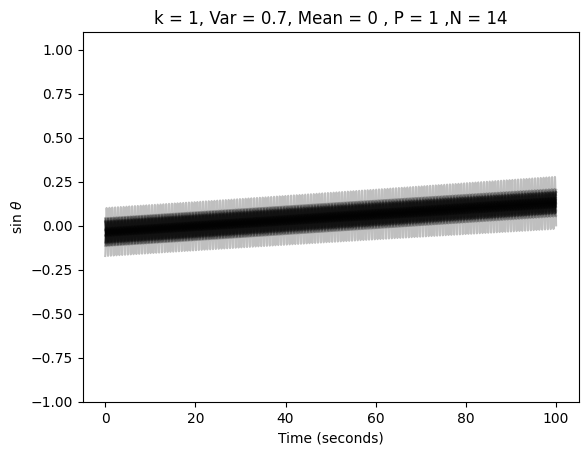

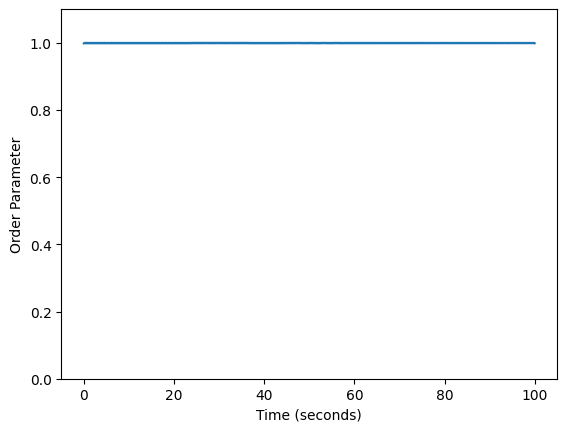

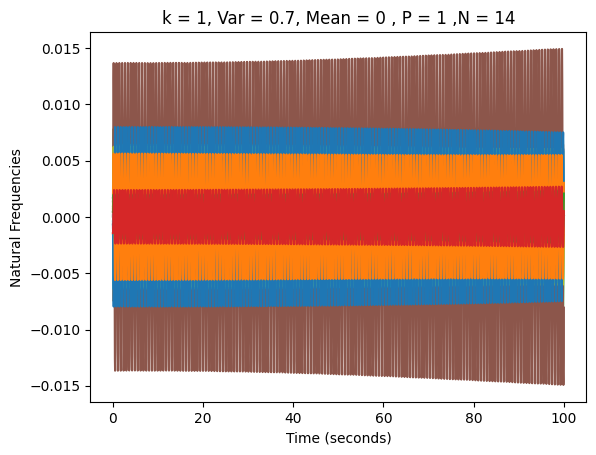

In [ ]:
fig, ax = plt.subplots()
for i in range(N):
    ax.plot(time,results[:,i],color='black', alpha=0.25
            ) 
    
ax.set_ylim([-1, 1.1])

ax.set_xlabel('Time (seconds)')
ax.set_ylabel(r"sin $\theta $")
ax.set_title(f'k = {k}, Var = {var}, Mean = {mean} , P = {connectivity} ,N = {N}')
fig, ax = plt.subplots()
# print(np.exp(1j*results))
# print(np.mean(np.exp(1j*results)))
OP = np.abs(np.mean(np.exp(1j*theta), axis=1))
ax.plot(time, OP)
ax.set_ylim([-0, 1.1])

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Order Parameter')

fig, ax = plt.subplots()
for i in range(0,testnet.n):
    ax.plot(time,testnet.nat_hist[i][0:-1])
ax.set_xlabel('Time (seconds)')
ax.set_ylabel(r"Natural Frequencies")
ax.set_title(f'k = {k}, Var = {var}, Mean = {mean} , P = {connectivity} ,N = {N}')
    

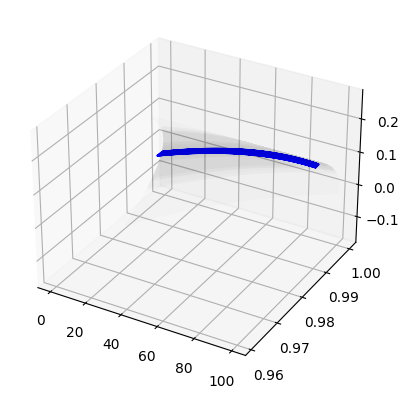

In [ ]:
ax = plt.axes(projection='3d')
ax.plot3D(time,np.abs(np.mean(np.exp(1j*theta), axis=1))*np.cos(np.mean(theta,axis=1)), np.abs(np.mean(np.exp(1j*theta), axis=1))*np.sin(np.mean(theta,axis=1)), 'blue',alpha = 1)

for i in range(0,N):
    ax.plot3D(time,np.cos(theta[:,i]), np.sin(theta[:,i]),  'black',alpha = 0.01)



    

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (100,)  and requested shape (10000,)

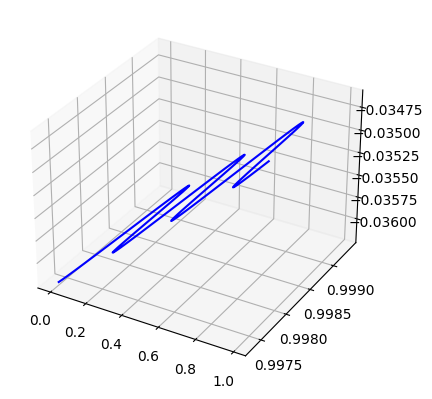

In [ ]:
# Plot the points for all oscillators  and r
N=100
ax = plt.axes(projection='3d')
ax.plot3D(time[0:N],np.abs(np.mean(np.exp(1j*theta[0:N,:]), axis=1))*np.cos(np.mean(theta[0:N,:],axis=1)), np.abs(np.mean(np.exp(1j*theta[0:N,:]), axis=1))*np.sin(np.mean(theta[0:N,:],axis=1)), 'blue',alpha = 1)

for i in range(0,N):
    ax.plot3D(time,np.cos(theta[0:N,i]), np.sin(theta[0:N,i]),  'black',alpha = 0.1)

In [ ]:
testnet.reinit()

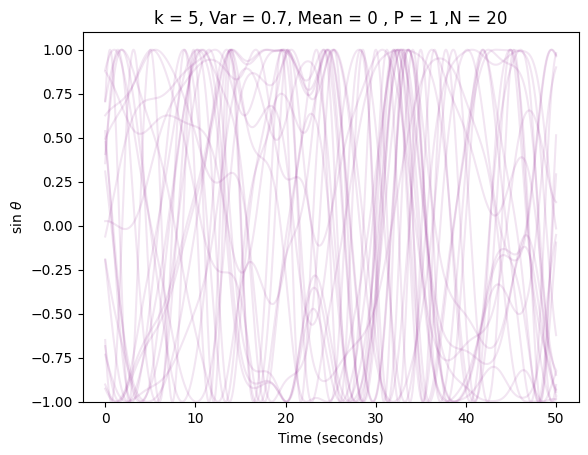

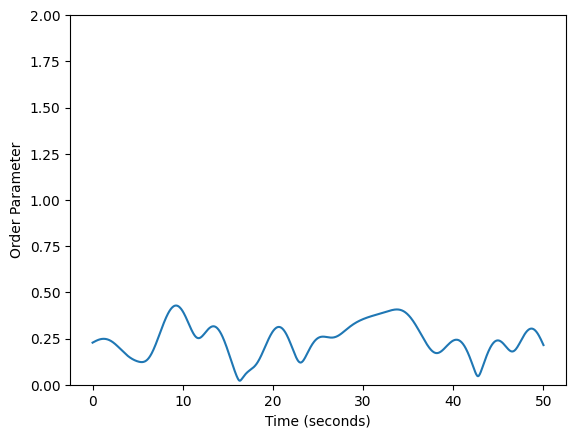

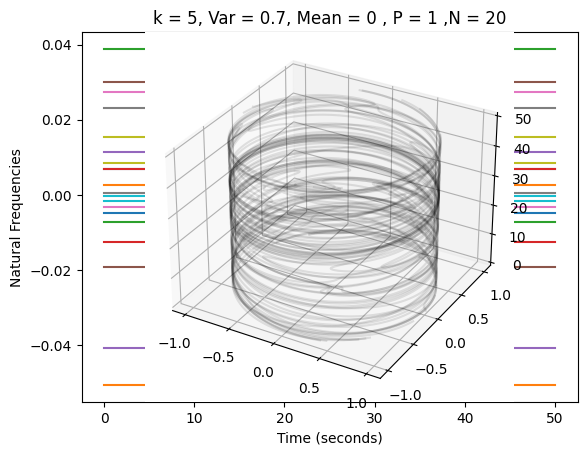

In [ ]:
T = 50
res = 1000
time = np.linspace(0,T,res)
dt = T/res
RunAndPlot(Qnat,Qup,time,testnet,res,N,k,var,mean,connectivity)

# Parameter Sweeps


In [ ]:
## Saving functionality 
'''
Save file is set as N,k,p,var,mean
''' 
f = open(f'C:\\Users\\Harri\\OneDrive - The University of Manchester\\PhD\\Code\\Bayesian\\Python_Compsol\\{N}_{k}_{connectivity}_{mean}_{var}','w')
writer = csv.writer(f)

header = ['t']
for i in range(N):
    header.append(f'theta_{i+1}')
writer.writerow(header)
f.close()



